# Emission Measure

In [29]:
import os
import sys
import glob
import copy

import numpy as np
from scipy.interpolate import splev,interp1d
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sunpy.map import Map,GenericMap
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from astropy.coordinates import SkyCoord
import distributed

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from dem import HannahKontarModel, make_slope_map_tpeak

sys.path.append('../paper/python/')
from formatting import hist_step

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [94]:
def make_slope_map(emcube, temperature_lower_bound=None, em_threshold=None):
    """
    Fit emission measure distribution in every pixel
    
    The fit is computed between `temperature_lower_bound`
    and the temeperature at which the EM is maximum.
    
    Parameters
    ----------
    emcube: `EMCube`
        Emission measure map as a function space and temperature
    em_threshold: `~astropy.units.Quantity`, optional
        If the total EM in a pixel is below this, no slope is calculated
        
    Returns
    -------
    slope_map: `~sunpy.map.GenericMap`
    rsquared_map: `~sunpy.map.GenericMap`
    """
    if em_threshold is None:
        em_threshold = u.Quantity(1e25, u.cm**(-5))
    i_valid = np.where(u.Quantity(emcube.total_emission.data, emcube[0].meta['bunit']) > em_threshold)
    em_valid = np.log10(emcube.as_array()[i_valid])
    em_valid[np.logical_or(np.isinf(em_valid), np.isnan(em_valid))] = 0.0
    i_peak = em_valid.argmax(axis=1)
    log_temperature_bin_centers = np.log10(emcube.temperature_bin_centers.value)
    if temperature_lower_bound is None:
        i_lower = 0
    else:
        i_lower = np.fabs(emcube.temperature_bin_centers - temperature_lower_bound).argmin()
    slopes,rsquared = [],[]
    for emv,ip in zip(em_valid,i_peak):
        t_fit = log_temperature_bin_centers[i_lower:ip]
        if t_fit.size < 3:
            warnings.warn('Fit should be over 3 or more bins in temperature.')
        if t_fit.size == 0:
            slopes.append(np.nan)
            rsquared.append(0.)
            continue
        em_fit = emv[i_lower:ip]
        w = np.where(em_fit>0, 1, 0)
        coeff,rss,_,_,_ = np.polyfit(t_fit, em_fit, 1, full=True, w=w)
        rss = 1 if rss.size == 0 else rss[0]
        _,rss_flat,_,_,_ = np.polyfit(t_fit, em_fit, 0, full=True, w=w)
        rss_flat = 1 if rss_flat.size == 0 else rss_flat[0]
        slopes.append(coeff[0])
        rsquared.append(1-rss/rss_flat)
    slopes_data = np.zeros(emcube.total_emission.data.shape)
    slopes_data[i_valid] = slopes
    rsquared_data = np.zeros(emcube.total_emission.data.shape)
    rsquared_data[i_valid] = rsquared
    
    return Map(slopes_data, emcube[0].meta,), Map(rsquared_data, emcube[0].meta)

In [2]:
cluster = distributed.LocalCluster(n_workers=32,threads_per_worker=2)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33880 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 64 Memory: 270.38 GB


First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [3]:
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_201102*_{}_cutout.fits'

In [4]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [5]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(read_template.format(c['name'])) for c in aia.channels])

Next, set up the temperature bins.

In [6]:
temperature_bin_edges = 10.**np.arange(5.5,7.3,0.1) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [7]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Next, we'll time-average the emission in each channel

In [8]:
maps = [cube[c['name']].average(
            chunks=(cube[c['name']].shape[0], cube[c['name']].shape[1]//5, cube[c['name']].shape[2]//5)) 
        for c in aia.channels]

and normalize each map to the exposure time

In [9]:
maps = [Map(m.data/m.meta['exptime'], m.meta) for m in maps]

And finally compute the EM distribution using the method of HK12 in IDL.

In [10]:
hk_model = HannahKontarModel(
    maps,
    temperature_bin_edges,
    responses,
    dem_path='/storage-home/w/wtb2/codes/demreg/idl/'
)

In [11]:
em = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

Now, compute the emission measure slope in each pixel by fitting over the interval $[10^6,T_{peak}]$, where $T_{peak}$ is the temperature at the peak of the emission measure distribution.

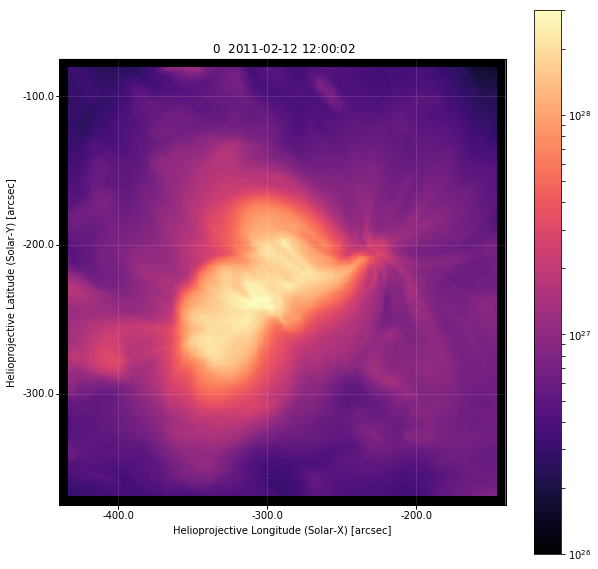

In [70]:
em_total = em.total_emission
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=em_total)
em_total.plot(axes=ax,vmin=1e26,vmax=3e28)
plt.colorbar()

In [103]:
slope_map,rsquared_map = make_slope_map(
    em,
    em_threshold=1.75e27*(u.cm**(-5)),
    temperature_lower_bound=8e5*u.K,
)
slope_map.save('../paper/data/observations/em_slope.fits', overwrite=True)
rsquared_map.save('../paper/data/observations/em_slope_rsquared.fits', overwrite=True)

/storage-home/w/wtb2/anaconda3/envs/synthetic-observables/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10


In [101]:
sm.bottom_left_coord

<SkyCoord (Helioprojective: obstime=2011-02-12 12:00:02.120000, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2011-02-12 12:00:02.120000): (lon, lat, radius) in (deg, deg, m)
    (0., -6.68918, 1.47686817e+11)>): (Tx, Ty) in arcsec
    (-439.49933487, -374.69873724)>

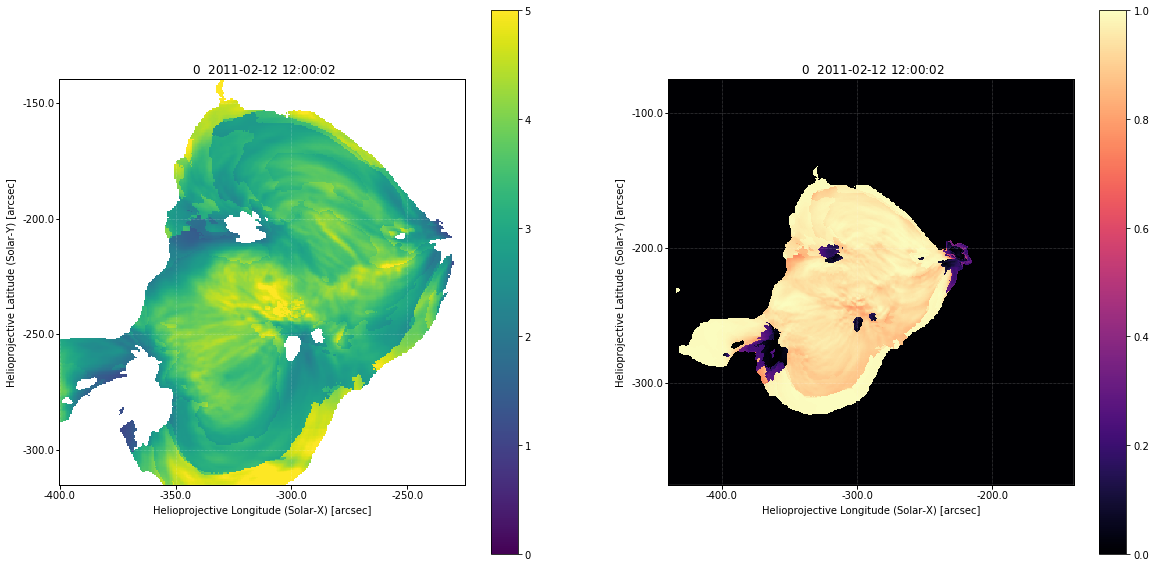

In [104]:
fig = plt.figure(figsize=(20,10))
sm = Map(slope_map.data, slope_map.meta, mask=rsquared_map.data < 0.75)
sm = sm.submap(
    SkyCoord(Tx=-400*u.arcsec,Ty=-315*u.arcsec,frame=sm.coordinate_frame),
    SkyCoord(Tx=-225*u.arcsec,Ty=-140*u.arcsec,frame=sm.coordinate_frame)
)
ax = fig.add_subplot(121,projection=sm)
sm.plot(axes=ax,cmap='viridis',vmin=0,vmax=5)
plt.colorbar()
sm = rsquared_map
ax = fig.add_subplot(122,projection=sm)
sm.plot(axes=ax,cmap='magma',vmin=0,vmax=1)
plt.colorbar()

(0.5, 7.5)

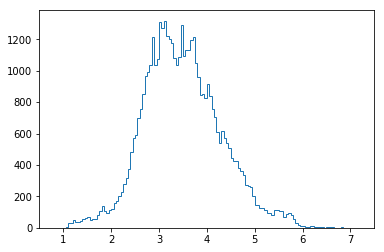

In [97]:
plt.hist(slope_map.data[rsquared_map.data > 0.75].flatten(),bins=np.arange(0,7,0.05),histtype='step');
plt.xlim(0.5,7.5)

(1e+25, 1e+28)

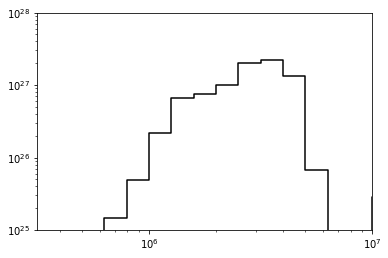

In [34]:
em1d = em.get_1d_distribution(
    SkyCoord(Tx=-330*u.arcsec,Ty=-290*u.arcsec,frame=em[0].coordinate_frame),
    SkyCoord(Tx=-329*u.arcsec,Ty=-289*u.arcsec,frame=em[0].coordinate_frame)
)
ax = plt.figure().gca()
hist_step(ax,em1d.value,temperature_bin_edges.value,color='k')
#ax.plot(10**temperature_fit,(10**coeff[1])*(10**temperature_fit)**coeff[0],color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10**5.5,10**7)
plt.ylim(1e25,1e28)

In [36]:
em.temperature_bin_centers.to(u.MK)

<Quantity [ 0.35716747,  0.4496472 ,  0.56607229,  0.71264279,  0.89716412,
            1.12946271,  1.4219093 ,  1.79007775,  2.25357437,  2.83708205,
            3.57167468,  4.49647202,  5.66072289,  7.1264279 ,  8.97164117,
           11.29462706, 14.21909302] MK>